In [1]:
# All imports

%matplotlib inline

import cv2
import glob, os
import imageio
import matplotlib.pyplot as plt
import numpy

from keras.layers import Dense, Dropout
from keras.models import Sequential

from skimage import feature
from sklearn.svm import SVC

Using TensorFlow backend.


In [2]:
# All image processing and plot related

def plotImage(image):
    cv_rgb2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb2)
    plt.show()

def plotImageFromPath(imagePath):
    plotImage(cv2.imread(imagePath))

def shape_cannyEdgesOld(cv2Image, cannyImagePath):
    v = numpy.median(cv2Image)
    sigma = 0.0
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    #print "Lower", lower, "Upper", upper
    grayScaleImage = cv2.cvtColor(cv2Image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(grayScaleImage, 10, 255)
    cv2.imshow('Canny edges',edges)
    cv2.imwrite(cannyImagePath, edges)

def shape_cannyEdges(cv2Image, cannyImagePath):
    cv2Image[0,0] = (255, 0, 0)
    cv2Image[0,1] = (0, 255, 0)
    cv2Image[0,2] = (0, 0, 255)
    
    v = numpy.median(cv2Image)
    sigma = 0.0
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    #print "Lower", lower, "Upper", upper
    grayScaleImage = cv2.cvtColor(cv2Image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(grayScaleImage, 10, 255)
    cv2.imshow('Canny edges',edges)
    cv2.imwrite(cannyImagePath, edges)
    
def shape_hog(cv2Image, fileName): 
    grayScaleImage = cv2.cvtColor(cv2Image, cv2.COLOR_BGR2GRAY)
    fd, hog_image = feature.hog(grayScaleImage, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualise=True)
    
    cv2.imshow('HOG',hog_image)
    cv2.imwrite(fileName, hog_image)
    
def create_canny_edge_image(origImageDir, origImageName):
    
    origImagePath = origImageDir + '/' + origImageName
    print(origImagePath)
    
    cannyImageName = "canny_" + origImageName
    cannyImagePath = origImageDir + '/' + cannyImageName
    plainImage = cv2.imread(origImagePath)
    shape_cannyEdges(plainImage, cannyImagePath)
    
    return cannyImagePath
    
def create_canny_for_all_img(origImageDir):
    imgFiles = [filename for filename in os.listdir(origImageDir)
                if (not filename.startswith("canny") and filename.endswith(".jpg") )]
    for origImageName in imgFiles:
        cannyImageName = "canny_" + origImageName
        cannyImagePath = origImageDir + '/' + cannyImageName
        
        if not os.path.exists(cannyImagePath):
            create_canny_edge_image(origImageDir, origImageName)
            
def create_color_histogram (origImageDir, origImageName):
    origImagePath = origImageDir + '/' + origImageName
    plainImage = cv2.imread(origImagePath)
    
    hist = cv2.calcHist([plainImage], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = hist.flatten()
    print (hist)

In [7]:
# All image feature verctor related

def create_features_for_all_raw_img(origImageDir, isSpam):
    imgFiles = [filename for filename in os.listdir(origImageDir)
                if ((not filename.startswith("canny")) and filename.endswith(".jpg") )]
    res = [create_feature_vector(origImageDir, origImageName, isSpam) for origImageName in imgFiles]
    return numpy.array(res)
            
def create_features_for_all_canny_img(origImageDir, isSpam):
    imgFiles = [filename for filename in os.listdir(origImageDir)
                if (filename.startswith("canny") and filename.endswith(".jpg") )]
    res = [create_feature_vector(origImageDir, origImageName, isSpam) for origImageName in imgFiles]
    return numpy.array(res)
    
def create_feature_vector(origImageDir, origImageName, isSpam, numRow=32, numCol=32):
    origImagePath = origImageDir + '/' + origImageName
    plainImage = cv2.imread(origImagePath)
    resizedImage = cv2.resize(plainImage, (numRow, numCol))
    h = resizedImage.shape[0]
    w = resizedImage.shape[1]
    res = numpy.ndarray(shape=(h,w), dtype=float, order='F')
    # loop over the image, pixel by pixel
    for y in range(0, h):
        for x in range(0, w):
            # threshold the pixel
            color = resizedImage[y,x] 
            r = color[0] / 255.0
            g = color[1] / 255.0
            b = color[2] / 255.0
            res[y, x] = r + g + b
    return numpy.append(res.flatten(), isSpam)
        
def get_feature_with_labels(howMany=None, nonSpamDir="NaturalImages", spamDir="SpamImages"):
    create_canny_for_all_img(nonSpamDir)
    data_nonSpam_raw = create_features_for_all_raw_img(nonSpamDir, 0)
    data_nonSpam_canny = create_features_for_all_canny_img(nonSpamDir, 0)
    data_nonSpam = numpy.column_stack((data_nonSpam_raw[:,:-1], data_nonSpam_canny))

    create_canny_for_all_img(spamDir)
    data_Spam_raw = create_features_for_all_raw_img(spamDir, 1)
    data_Spam_canny = create_features_for_all_canny_img(spamDir, 1)
    data_Spam = numpy.column_stack((data_Spam_raw[:,:-1], data_Spam_canny))
    
    data = numpy.concatenate((data_nonSpam, data_Spam), axis=0)
    numpy.random.shuffle(data)

    print("data_nonSpam, using directory:", nonSpamDir)
    print(data_nonSpam)
    print("data_Spam, using directory:", spamDir)
    print(data_Spam)
    print("data")
    print(data)

    if howMany is not None:
        data = data[0:howMany]

    return data

In [8]:
# For testing, uncomment and save data to reuse
data = get_feature_with_labels(nonSpamDir="NaturalImages", spamDir="SpamImages")

data_nonSpam, using directory:  NaturalImages
[[0.         0.         0.00392157 ... 0.         0.51764706 0.        ]
 [0.85490196 1.58039216 1.60784314 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.55294118 0.59215686 0.63529412 ... 0.         0.         0.        ]
 [0.55294118 0.57647059 0.56078431 ... 0.         0.         0.        ]
 [1.18823529 2.36862745 2.5372549  ... 0.         0.         0.        ]]
data_Spam, using directory:  SpamImages
[[0.39215686 2.49411765 0.41176471 ... 0.         0.         1.        ]
 [2.69803922 2.6627451  2.65098039 ... 0.         0.         1.        ]
 [3.         3.         3.         ... 0.         0.         1.        ]
 ...
 [2.45882353 2.41568627 2.4627451  ... 0.         0.         1.        ]
 [3.         3.         3.         ... 0.         0.         1.        ]
 [2.51764706 2.96470588 2.85882353 ... 0.         0.         1.        ]]
data
[[0.49019608 0.270588

In [9]:
# Machine learning algorithm related

def run_feed_forward(data, do_plot=False):
    
    INPUT_DIMENSION = 2048
    LAYER_1_DIMENSION = 300
    LAYER_2_DIMENSION = 300
    OUTPUT_DIMENSION = 1
    
    train_len = int(len(data) * .7)
    data_train = data[0:train_len]
    data_test = data[train_len:]

    num_col = len(data_train[0]) - 1

    x_train = data_train[:, 0:num_col]
    y_train = data_train[:, num_col:].flatten()

    x_test = data_test[:, 0:num_col]
    y_test = data_test[:, num_col:].flatten()

    model = Sequential()
    model.add(Dense(LAYER_1_DIMENSION, input_dim=INPUT_DIMENSION, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(LAYER_2_DIMENSION, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(OUTPUT_DIMENSION, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train,
              epochs=10,
              batch_size=64)
    score = model.evaluate(x_test, y_test, batch_size=64)
    print (score)
    
    if do_plot:
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    return score

# Svm
def run_svm(data):
    
    train_len = int(len(data) * .7)
    data_train = data[0:train_len]
    data_test = data[train_len:]
    
    num_col = len(data_train[0]) - 1
    
    x_train = data_train[:, 0:num_col]
    y_train = data_train[:, num_col:].flatten()
    
    x_test = data_test[:, 0:num_col]
    y_test = data_test[:, num_col:].flatten()
    
    clf = SVC(C=1.0, kernel='rbf')
    clf.fit(x_train, y_train)
    clf.predict(x_test)
    score = clf.score(x_test, y_test) 
    print (score)
    return score

Epoch 1/10
1167/1167 [==============================] - 1s 615us/step - loss: 4.3159 - acc: 0.6093
Epoch 2/10
1167/1167 [==============================] - 0s 322us/step - loss: 0.5146 - acc: 0.8380
Epoch 3/10
1167/1167 [==============================] - 0s 352us/step - loss: 0.3250 - acc: 0.8929
Epoch 4/10
1167/1167 [==============================] - 0s 262us/step - loss: 0.3041 - acc: 0.9049
Epoch 5/10
1167/1167 [==============================] - 0s 244us/step - loss: 0.3313 - acc: 0.8972
Epoch 6/10
1167/1167 [==============================] - 0s 262us/step - loss: 0.2366 - acc: 0.9246
Epoch 7/10
1167/1167 [==============================] - 0s 285us/step - loss: 0.2859 - acc: 0.9083
Epoch 8/10
1167/1167 [==============================] - 0s 314us/step - loss: 0.1655 - acc: 0.9460
Epoch 9/10
1167/1167 [==============================] - 0s 306us/step - loss: 0.2940 - acc: 0.9186
Epoch 10/10
501/501 [==============================] - 0s 203us/step
[0.2030908512379119, 0.9321357316361691]

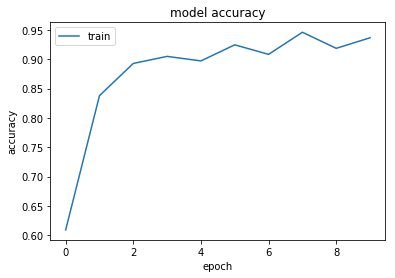

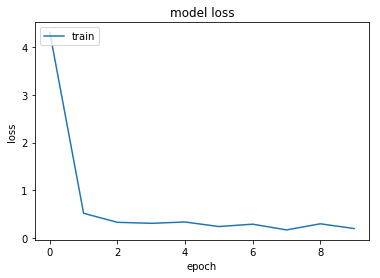

0.9321357316361691


In [10]:
# Main
    
def main():
    # This runs the model 10 times with x number of rows
    #numRowsToConsider = 100
    numRowsToConsider = None
    numIter = 1
    sum = 0
    for i in range(0, numIter):
        #data = get_feature_with_labels(numRowsToConsider, nonSpamDir="NaturalImages", spamDir="SpamImages")
        #sum += run_svm(data)
        sum += run_feed_forward(data, True)[1]
    sum /= numIter
    print (sum)

main()

In [ ]:
# This section and rest are just tests
def extract_features(imagePath, vector_size=32):
    image = imageio.imread(imagePath)
    alg = cv2.KAZE_create()
    kps = alg.detect(image)
    kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
    print (len(kps))
    kps, dsc = alg.compute(image, kps)
    print (len(dsc))
    print (len(dsc[0]))
    dsc = dsc.flatten()
    print (len(dsc))
    needed_size = (vector_size * 32)
    if dsc.size < needed_size:
        dsc = numpy.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    return dsc

def main2():
    #features = create_feature_vector("SpamImages", "fire.jpg")
    #print len(features)
    #print features
    #image = cv2.imread("SpamImages/fire.jpg")
    #plotImage(image)
    #image2 = cv2.resize(image, (600, 600))
    #plotImage(image2)
    
    
    """data = get_feature_with_labels()
    data"""
    
    #print (len(data[0]))
    
    

    #create_feature_vector_for_canny("NaturalImages", origImageName)
    
    #plainImageFileName = "SpamImages/boots1.jpg"
    """plainImage =  cv2.imread(plainImageFileName)
    shape_hog(plainImage, "HOG-Ham.png")
    
    #plt.imshow(plainImage, cmap = 'gray', interpolation = 'bicubic')
    #plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    #plt.show()
    cv_rgb = cv2.cvtColor(plainImage, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    plainImage2 =  cv2.imread("HOG-Ham.png")

    print "hi"
    
    cv_rgb2 = cv2.cvtColor(plainImage2, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb2)
    plt.show()

    shape_cannyEdges(plainImage)
    cv_rgb2 = cv2.cvtColor(cv2.imread("Cannyedges.jpg"), cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb2)
    plt.show()"""
    
    #x = create_feature_vector_for_canny("SpamImages", "fire.jpg", 3.0)
    numpy.set_printoptions(threshold=100)
    #print x
    
    x = numpy.ndarray((10, 3))
    print(x)
    train_len = int(len(x) * .7)
    #print x[0:train_len]
    #print "sep"
    #print x[train_len:]
    
    num_col = len(x[0]) - 1
    
    print(x[:,0:num_col])
    
    print(x[:, num_col:].flatten())